In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

!pip install deepface opencv-python mtcnn -q

import cv2 
from mtcnn import MTCNN 
from deepface import DeepFace 
import matplotlib.pyplot as plt
import numpy as np
import glob 
import pandas as pd 
import time 
import tensorflow as tf
import keras
import torch 
device_torch = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"PyTorch device: {device_torch}")

gpu_devices_tf = tf.config.list_physical_devices('GPU')
if gpu_devices_tf:
    print(f"TensorFlow GPU detected: {gpu_devices_tf}")
    try:
        for gpu in gpu_devices_tf:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Could not set memory growth for TF GPU: {e}")
else:
    print("TensorFlow GPU not found.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.8 MB/s eta 0:00:00


2025-04-28 10:18:40.925188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745835521.102745      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745835521.154786      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


25-04-28 10:18:54 - Directory /root/.deepface has been created
25-04-28 10:18:54 - Directory /root/.deepface/weights has been created
PyTorch device: cuda
TensorFlow GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow GPU memory growth enabled.


In [2]:
gallery_base_path = "/kaggle/input/face-recognition-dataset/Original Images/Original Images"

try:
    all_persons = sorted([d for d in os.listdir(gallery_base_path) if os.path.isdir(os.path.join(gallery_base_path, d))])
    num_persons_to_process = 5 
    if len(all_persons) >= num_persons_to_process:
         selected_persons = all_persons[:num_persons_to_process]
         print(f"Found {len(all_persons)} persons. Processing first {num_persons_to_process}: {selected_persons}")
    else:
         print(f"Warning: Found only {len(all_persons)} persons, processing all.")
         selected_persons = all_persons
except FileNotFoundError:
    print(f"ERROR: Gallery path not found: {gallery_base_path}")
    print("Please ensure the dataset is added correctly and the path is updated.")
    selected_persons = [] 
    
print("Initializing MTCNN detector...")
try:
    detector = MTCNN()
    print("MTCNN detector initialized.")
except Exception as e:
    print(f"Error initializing MTCNN: {e}")
    detector = None 

face_database = []

embedding_model_name = 'Facenet512'
print(f"Using embedding model: {embedding_model_name}")

start_time = time.time()
total_images_processed = 0
total_faces_embedded = 0

if detector and selected_persons:
    for person_name in selected_persons:
        person_folder_path = os.path.join(gallery_base_path, person_name)
        image_files = glob.glob(os.path.join(person_folder_path, '*.[jJ][pP][gG]')) + \
                      glob.glob(os.path.join(person_folder_path, '*.[pP][nN][gG]')) + \
                      glob.glob(os.path.join(person_folder_path, '*.[jJ][pP][eE][gG]'))

        print(f"\nProcessing {person_name} ({len(image_files)} images)...")
        person_face_count = 0

        for img_path in image_files:
            total_images_processed += 1
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"  - Could not read image: {img_path}")
                    continue

                detected_faces = detector.detect_faces(img)

                if not detected_faces:
                    continue

                face_info = detected_faces[0]
                x, y, w, h = face_info['box']
                x, y = abs(x), abs(y)

                margin = 10 
                face_img = img[max(0, y-margin):min(img.shape[0], y+h+margin),
                               max(0, x-margin):min(img.shape[1], x+w+margin)]

                if face_img.size == 0:
                     print(f"  - Face crop resulted in empty image for: {img_path}")
                     continue

                embedding_objs = DeepFace.represent(img_path=face_img,
                                                     model_name=embedding_model_name,
                                                     enforce_detection=False, 
                                                     detector_backend='skip') 

                if embedding_objs and 'embedding' in embedding_objs[0]:
                    embedding = embedding_objs[0]['embedding']
                    face_database.append({
                        "identity": person_name,
                        "embedding": np.array(embedding)
                    })
                    person_face_count += 1
                    total_faces_embedded += 1
               
            except Exception as e:
                pass 

        print(f"  -> Found and embedded {person_face_count} faces for {person_name}.")

elif not detector:
     print("ERROR: MTCNN detector could not be initialized. Cannot process gallery.")
else:
     print("ERROR: No persons selected or gallery path is incorrect.")


end_time = time.time()
print(f"\n--- Gallery Processing Finished ---")
print(f"Total images checked: {total_images_processed}")
print(f"Total faces embedded: {total_faces_embedded}")
print(f"Total time: {end_time - start_time:.2f} seconds")

print(f"Face database contains {len(face_database)} entries.")
if face_database:
    print(f"Example entry: identity='{face_database[0]['identity']}', embedding shape={face_database[0]['embedding'].shape}")

import pickle

with open('face_database.pkl', 'wb') as f:
    pickle.dump(face_database, f)
print("Face database saved to face_database.pkl")

Found 31 persons. Processing first 5: ['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg']
Initializing MTCNN detector...


I0000 00:00:1745835538.772723      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


MTCNN detector initialized.
Using embedding model: Facenet512

Processing Akshay Kumar (50 images)...
25-04-28 10:19:02 - facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5
100%|██████████| 95.0M/95.0M [00:02<00:00, 39.7MB/s]
I0000 00:00:1745835546.477783      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


  -> Found and embedded 47 faces for Akshay Kumar.

Processing Alexandra Daddario (92 images)...
  -> Found and embedded 92 faces for Alexandra Daddario.

Processing Alia Bhatt (79 images)...
  -> Found and embedded 78 faces for Alia Bhatt.

Processing Amitabh Bachchan (74 images)...
  -> Found and embedded 44 faces for Amitabh Bachchan.

Processing Andy Samberg (92 images)...
  -> Found and embedded 90 faces for Andy Samberg.

--- Gallery Processing Finished ---
Total images checked: 387
Total faces embedded: 351
Total time: 535.48 seconds
Face database contains 351 entries.
Example entry: identity='Akshay Kumar', embedding shape=(512,)
Face database saved to face_database.pkl


Test edilecek resim sayısı: 7
Using threshold: 0.4 for model 'Facenet512' and metric 'cosine'
Required variables (detector, face_database) seem to exist.

--- Processing 7 Test Images (Manual Comparison) ---

Processing: Jessica Alba_100.jpg
--------------------------------
Found 1 faces.
  -> No close match found (Min Distance: 0.7088 > Threshold: 0.4)


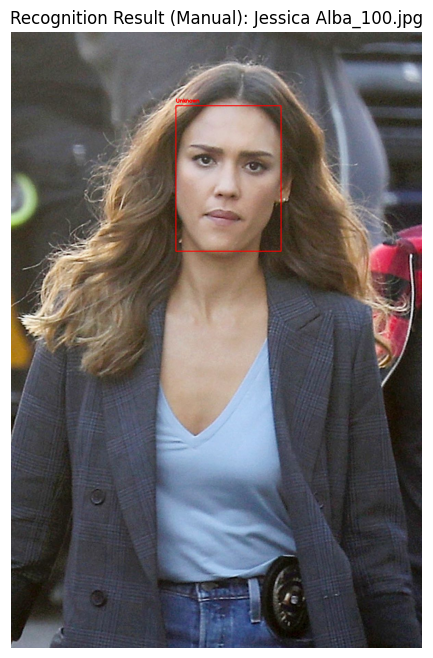


Processing: Akshay Kumar_1.jpg
------------------------------
Found 1 faces.
  -> Match Found: Akshay Kumar (Distance: 0.0236)


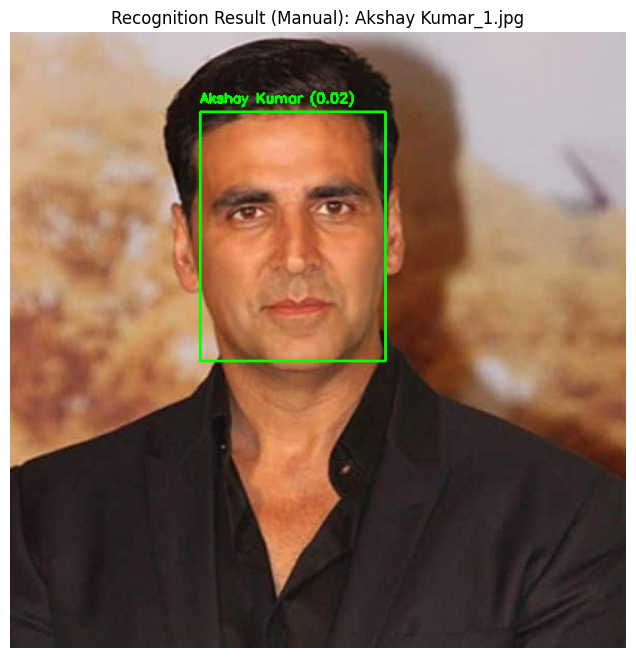


Processing: Alexandra Daddario_15.jpg
-------------------------------------
Found 1 faces.
  -> Match Found: Alexandra Daddario (Distance: 0.0153)


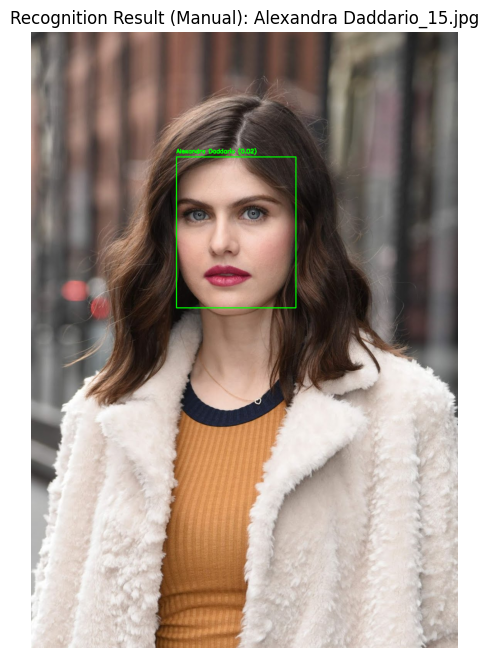


Processing: Natalie Portman_11.jpg
----------------------------------
Found 1 faces.
  -> No close match found (Min Distance: 0.5689 > Threshold: 0.4)


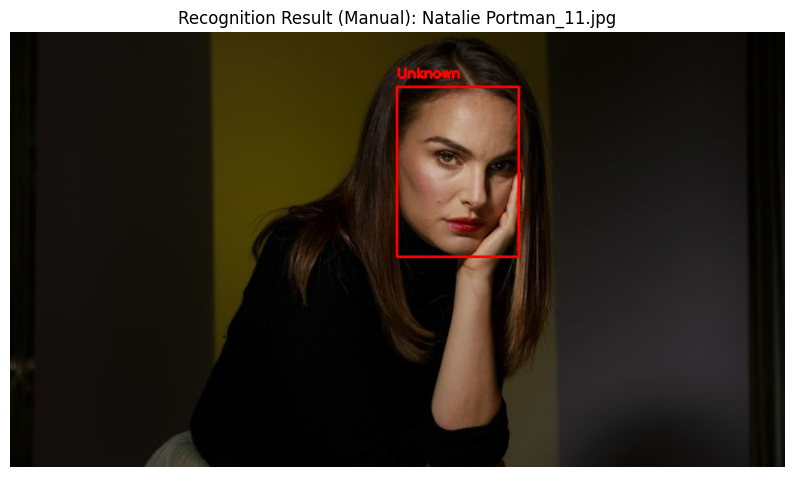


Processing: Alia Bhatt_23.jpg
-----------------------------
Found 1 faces.
  -> Match Found: Alia Bhatt (Distance: 0.0600)


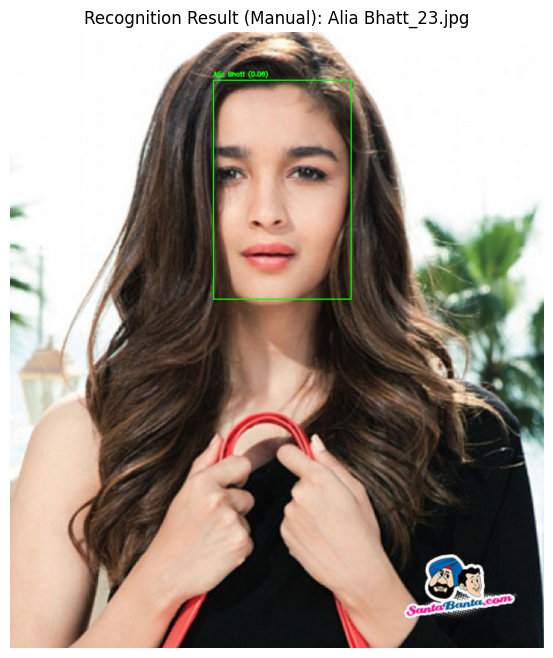


Processing: Amitabh Bachchan_19.jpg
-----------------------------------
Found 1 faces.
  -> Match Found: Amitabh Bachchan (Distance: 0.0932)


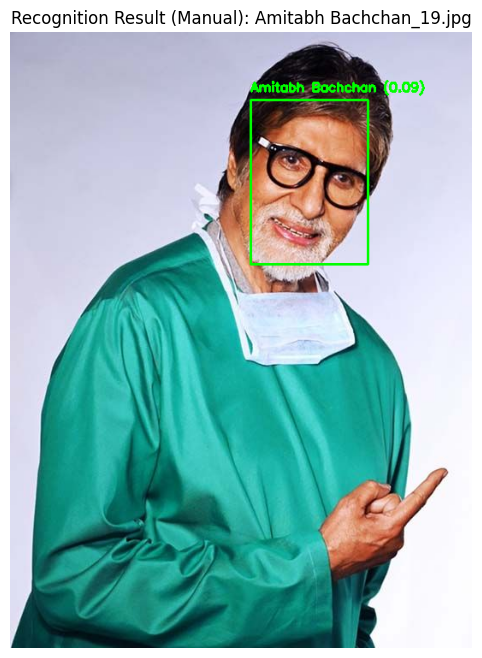


Processing: Andy Samberg_17.jpg
-------------------------------
Found 1 faces.
  -> Match Found: Andy Samberg (Distance: 0.0309)


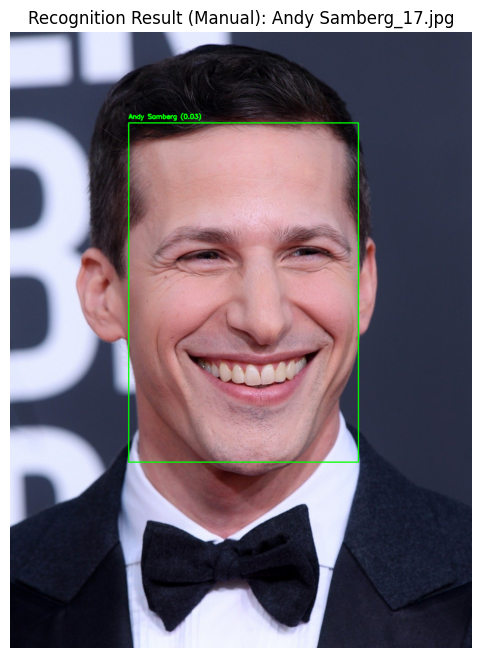

In [3]:
import pandas as pd 
import math
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np 
from mtcnn import MTCNN 
from deepface import DeepFace
import time

def findCosineDistance(source_representation, test_representation):
    source_representation = np.array(source_representation)
    test_representation = np.array(test_representation)
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    if b == 0 or c == 0:
        return float('inf') 
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

test_image_paths = [
    "/kaggle/input/face-recognition-dataset/Original Images/Original Images/Jessica Alba/Jessica Alba_100.jpg",
    "/kaggle/input/face-recognition-dataset/Original Images/Original Images/Akshay Kumar/Akshay Kumar_1.jpg",
    "/kaggle/input/face-recognition-dataset/Original Images/Original Images/Alexandra Daddario/Alexandra Daddario_15.jpg",
    "/kaggle/input/face-recognition-dataset/Original Images/Original Images/Natalie Portman/Natalie Portman_11.jpg",
    "/kaggle/input/face-recognition-dataset/Original Images/Original Images/Alia Bhatt/Alia Bhatt_23.jpg",
    "/kaggle/input/face-recognition-dataset/Original Images/Original Images/Amitabh Bachchan/Amitabh Bachchan_19.jpg",
    "/kaggle/input/face-recognition-dataset/Original Images/Original Images/Andy Samberg/Andy Samberg_17.jpg"
    
]
print(f"Test edilecek resim sayısı: {len(test_image_paths)}")

embedding_model_name = 'Facenet512'
distance_metric = 'cosine'
thresholds = {
    'VGG-Face': {'cosine': 0.40}, 'Facenet': {'cosine': 0.40},
    'Facenet512': {'cosine': 0.40}, 'ArcFace': {'cosine': 0.68},
    'DeepFace': {'cosine': 0.23} 
}
recognition_threshold = thresholds.get(embedding_model_name, {}).get(distance_metric, 0.4)
print(f"Using threshold: {recognition_threshold} for model '{embedding_model_name}' and metric '{distance_metric}'")

try:
    if 'detector' not in locals() or detector is None: raise NameError("detector (MTCNN)")
    if 'face_database' not in locals() or not face_database: raise NameError("face_database")
    if 'device' not in locals(): device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Required variables (detector, face_database) seem to exist.")
except NameError as e:
    print(f"ERROR: Required variable {e} is not defined or empty. Please run previous steps (A.3).")
    raise

print(f"\n--- Processing {len(test_image_paths)} Test Images (Manual Comparison) ---")

for test_image_path in test_image_paths:
    print(f"\nProcessing: {os.path.basename(test_image_path)}")
    print("-" * (len(os.path.basename(test_image_path)) + 12))
    try:
        img_bgr = cv2.imread(test_image_path)
        if img_bgr is None:
            raise FileNotFoundError(f"Test image not found: {test_image_path}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_display = img_rgb.copy()

        detected_faces_test = detector.detect_faces(img_rgb)
        print(f"Found {len(detected_faces_test)} faces.")

        if not detected_faces_test:
             plt.figure(figsize=(8, 8)); plt.imshow(img_display); plt.axis('off')
             plt.title(f"No Faces Detected: {os.path.basename(test_image_path)}"); plt.show()
             continue

        for face_info in detected_faces_test:
            x, y, w, h = face_info['box']
            x, y = abs(x), abs(y)

            margin = 10
            face_img_crop_rgb = img_rgb[max(0, y-margin):min(img_rgb.shape[0], y+h+margin),
                                    max(0, x-margin):min(img_rgb.shape[1], x+w+margin)]

            if face_img_crop_rgb.size == 0:
                print("  - Skipping empty face crop.")
                continue

            recognized_name = "Unknown"
            min_distance = float('inf')
            best_match_identity = "Unknown"

            try:
                face_img_crop_bgr = cv2.cvtColor(face_img_crop_rgb, cv2.COLOR_RGB2BGR)
                embedding_objs = DeepFace.represent(img_path = face_img_crop_bgr,
                                                     model_name = embedding_model_name,
                                                     enforce_detection = False,
                                                     detector_backend = 'skip')

                if embedding_objs and 'embedding' in embedding_objs[0]:
                    test_embedding = embedding_objs[0]['embedding']

                    for db_entry in face_database:
                        gallery_embedding = db_entry['embedding']
                        identity = db_entry['identity']

                        distance = findCosineDistance(test_embedding, gallery_embedding)

                        if distance < min_distance:
                            min_distance = distance
                            best_match_identity = identity 

                    if min_distance <= recognition_threshold:
                        recognized_name = best_match_identity 
                        print(f"  -> Match Found: {recognized_name} (Distance: {min_distance:.4f})")
                    else:
                        print(f"  -> No close match found (Min Distance: {min_distance:.4f} > Threshold: {recognition_threshold})")
                        recognized_name = "Unknown"
                else:
                    print("  - Could not extract embedding for the detected face.")
                    recognized_name = "Unknown"
                    min_distance = float('inf')

            except Exception as e:
                print(f"  - Error during DeepFace.represent or comparison: {e}")
                recognized_name = "Unknown"
                min_distance = float('inf')

            label = f"{recognized_name} ({min_distance:.2f})" if recognized_name != "Unknown" and not math.isinf(min_distance) else "Unknown"
            color = (0, 255, 0) if recognized_name != "Unknown" else (255, 0, 0) 

            cv2.rectangle(img_display, (x, y), (x+w, y+h), color, 2)
            cv2.putText(img_display, label, (x, y-10 if y-10 > 10 else y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        plt.figure(figsize=(10, 8))
        plt.imshow(img_display)
        plt.axis('off')
        plt.title(f"Recognition Result (Manual): {os.path.basename(test_image_path)}")
        plt.show()
    except FileNotFoundError as e:
        print(f"Skipping image due to error: {e}")
    except RuntimeError as e:
        print(f"Skipping image due to error: {e}")
    except NameError as e:
         print(f"Skipping image due to NameError (check required variables?): {e}")
    except Exception as e:
        print(f"Skipping image due to unexpected error: {e}")
